# Transfer Learning

In [1]:
# downloaded keras_preprocessing from github (very important)

import numpy as np
import pandas as pd

#very important to use keras_preprocessing instead of  keras.preprocessing, flow_from_directory compatibility issues
from keras_preprocessing.image import ImageDataGenerator 

from keras.layers import Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, Input
from keras import applications
from keras.models import Model
from keras.utils import plot_model

Using TensorFlow backend.


#### Note: Cannot use tf.keras as tf.keras is incompatible with keras_prerpocessing.image, it only works with keras.preprocessing but flow_from_dataframe only works with keras_preprocessing.image

<https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1>

In [2]:
import time
import datetime

In [3]:
from tqdm.notebook import tqdm

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14293005201603870300
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3149044121
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5487786672898115508
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Preprocessing

In [5]:
prefix = "/data_final/"

In [6]:
# creating dataframe from labels.csv
data =  pd.read_csv(r"\labels_final.csv")
data.head()

,path,label
0,imagesv/v/o/h/voh71d00/509132755+-2755.tif,3
1,imagesl/l/x/t/lxt19d00/502213303.tif,3
2,imagesx/x/e/d/xed05a00/2075325674.tif,2
3,imageso/o/j/b/ojb60d00/517511301+-1301.tif,3
4,imagesq/q/z/k/qzk17e00/2031320195.tif,7


### Replacing the path with the actual path of images in the computer

In [7]:
def fullpath(path):
    return prefix+path

data['path']  = data['path'].apply(fullpath)

In [8]:
# path example
data['path'].iloc[0]

'C:/Users/rpris/Downloads/ml_data/transfer_learning/rvl-cdip/data_final/imagesv/v/o/h/voh71d00/509132755+-2755.tif'

### Replacing integers with string labels for flow_from_dataframe

In [9]:
data.replace({'label':{0: 'letter',
    1: 'form',
    2: 'email',
    3 :'handwritten',
    4 :'advertisement',
    5: 'scientific_report',
    6 :'scientific_publication',
    7 :'specification',
    8 :'file_folder',
    9 :'news_article',
    10 :'budget',
    11 :'invoice',
    12 :'presentation',
    13 :'questionnaire',
    14: 'resume',
    15 :'memo'}} , inplace=True)

In [10]:
data.head(3)

,path,label
0,C:/Users/rpris/Downloads/ml_data/transfer_lear...,handwritten
1,C:/Users/rpris/Downloads/ml_data/transfer_lear...,handwritten
2,C:/Users/rpris/Downloads/ml_data/transfer_lear...,email


### Dividing the data into train and test

In [11]:
#dividing the data into train and cross validation 
df_train = data.iloc[:33600]    # 70 % data is train
df_test = data.iloc[33600:]

### Train dataset

In [12]:

train_datagen =  ImageDataGenerator(rescale = 1./255)

test_datagen =  ImageDataGenerator(rescale = 1./255)

In [13]:
train_generator =  train_datagen.flow_from_dataframe(dataframe = df_train, directory = None, 
                                                     x_col= 'path', y_col='label',
                                                     class_mode='categorical')

Found 33600 validated image filenames belonging to 16 classes.


In [14]:
len(train_generator)      #number of generators or batches containing 32 images each

1050

### Test dataset

In [15]:
test_generator = test_datagen.flow_from_dataframe(dataframe=df_test, directory=None, 
                                                  x_col = 'path', y_col='label',
                                                 class_mode="categorical")

Found 14400 validated image filenames belonging to 16 classes.


# Model-1

Architecture  

 <b>INPUT --> VGG-16 without Top layers(FC) --> Conv Layer --> Maxpool Layer --> 2 FC layers --> Output Layer</b>

### Loading the weights of pretrained VGG 16 model trained on imagenet dataset

In [16]:
model_vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

### Freezing the layers

In [17]:
for layer in model_vgg16.layers:
    layer.trainable=False

In [18]:
model_vgg16.inputs    #list of all tensors as input is  giving error, using model.input instead of model.inputs

[<tf.Tensor 'input_1:0' shape=(None, 256, 256, 3) dtype=float32>]

In [20]:
from keras.backend import clear_session

In [21]:
clear_session()

### Creating the top model

In [22]:

#convolution layer 1
conv1 = Conv2D(32, kernel_size=3, activation='relu')(model_vgg16.output)

#maxpool layer
Maxpool = MaxPooling2D(pool_size=(2,2))(conv1)

#Flatten()
flat = Flatten()(Maxpool)

#dense layer 1
dens1 = Dense(256, activation='relu')(flat)

#dense layer 2
dens2 = Dense(128, activation='relu')(dens1)

#output
output = Dense(16, activation='softmax')(dens2)

#defining the model
model1 = Model(model_vgg16.input, outputs=output)

#compile with adam and cross_entropy
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model1.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

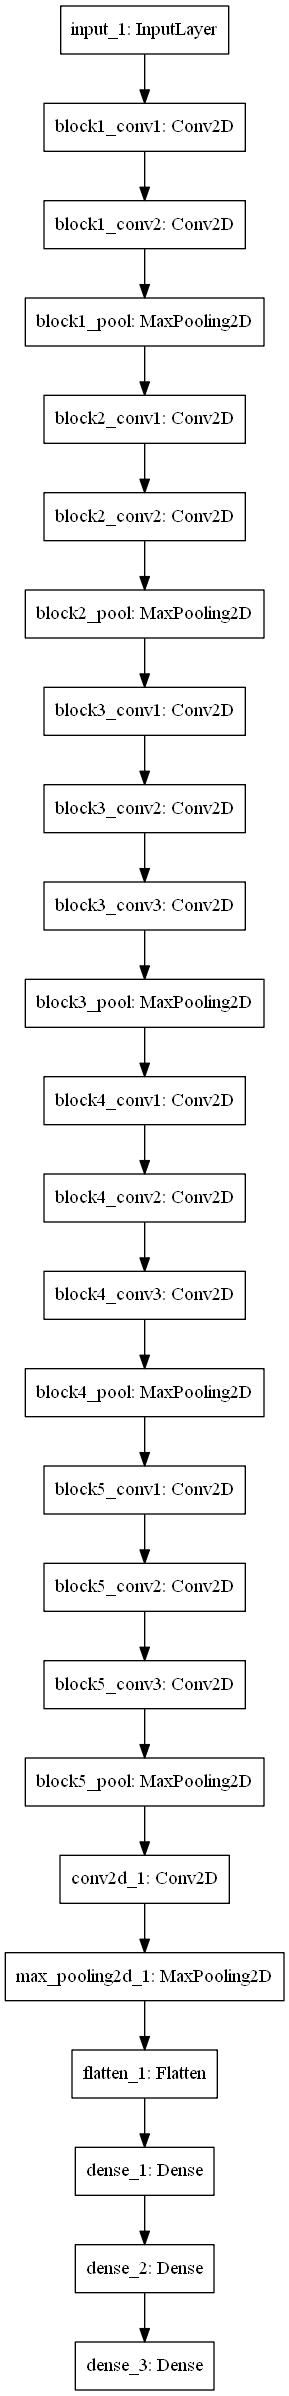

In [23]:
plot_model(model1,to_file='model1.png')

### CallBacks

In [17]:
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

In [18]:
#tensorboard callback #creating a new directory to store logs according to time
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S-") #dirctory according to time
tfboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1,write_graph=True)

#Early stopping callback to prevent overfitting
stp_callback = EarlyStopping(monitor='val_loss', mode='min', patience=3)


### FIT

In [33]:
model1.fit_generator(train_generator, epochs=30, 
                 validation_data = test_generator, callbacks=[tfboard_callback, stp_callback])

Epoch 1/30
1050/1050 [==============================] - 1282s 1s/step - loss: 1.1555 - accuracy: 0.6449 - val_loss: 1.6588 - val_accuracy: 0.6801
Epoch 2/30
1050/1050 [==============================] - 1287s 1s/step - loss: 0.9691 - accuracy: 0.7002 - val_loss: 0.9799 - val_accuracy: 0.7010
Epoch 3/30
1050/1050 [==============================] - 1289s 1s/step - loss: 0.8452 - accuracy: 0.7377 - val_loss: 0.7402 - val_accuracy: 0.7185
Epoch 4/30
1050/1050 [==============================] - 1275s 1s/step - loss: 0.7605 - accuracy: 0.7621 - val_loss: 0.8734 - val_accuracy: 0.7293
Epoch 5/30
1050/1050 [==============================] - 1227s 1s/step - loss: 0.6925 - accuracy: 0.7846 - val_loss: 1.1261 - val_accuracy: 0.7394
Epoch 6/30
1050/1050 [==============================] - 1253s 1s/step - loss: 0.6285 - accuracy: 0.8025 - val_loss: 0.7436 - val_accuracy: 0.7213


### Observation:
1. **Model starts to overfit after 3rd epoch, with patience=3 the overfitting is prevented**
2. **Validation accuracy is 71.85 %**

### Tensorboard M1 (red line is Validation)

<img src="https://imgur.com/zEW5FDG.png">

<img src="https://imgur.com/yFgBoLD.png">

# Model-2 

**Creating two fully connected layers of 1024 dimension**
Converting the first FC layer to Conv layer-  
    - Input to FC layer is 8x8x512(train_input.shape), so our Conv layer will be 8x8x1024 giving same output as FC i.e   1x1x1024  
    
Converting the second FC layer to Conv layer-  
    - Input to this FC layer is 1x1x1024, so our Conv layer will be 1x1x1024 giving same output as second FC i.e 1x1x4096
**Final layer is the output softmax layer of size 16**  

<b>INPUT --> VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer</b>

In [21]:

#FC layer converted to convolution
convv1 = Conv2D(1024, kernel_size=8, activation='relu')(model_vgg16.output)
convv2 = Conv2D(1024, kernel_size=1, activation='relu')(convv1)

#Flatten
flat = Flatten()(convv2)

#Output
output2 = Dense(16, activation='softmax')(flat)

#defining the model
model2 = Model(model_vgg16.inputs, outputs=output2)

#compile with adam and cross_entropy
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model summary
print(model2.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

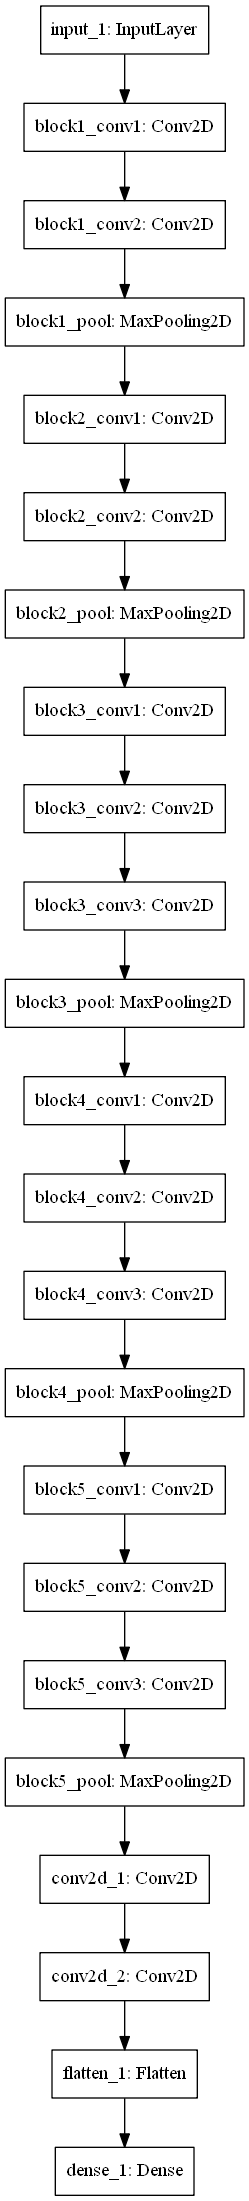

In [22]:
plot_model(model2, to_file='model2.png')

### FIT

In [23]:
model2.fit_generator(train_generator, epochs=30, 
                 validation_data = test_generator, callbacks=[tfboard_callback, stp_callback])

Epoch 1/30
1050/1050 [==============================] - 1257s 1s/step - loss: 1.3426 - accuracy: 0.6059 - val_loss: 1.4178 - val_accuracy: 0.6722
Epoch 2/30
1050/1050 [==============================] - 1287s 1s/step - loss: 0.9078 - accuracy: 0.7220 - val_loss: 1.0031 - val_accuracy: 0.6826
Epoch 3/30
1050/1050 [==============================] - 1291s 1s/step - loss: 0.7522 - accuracy: 0.7679 - val_loss: 1.0148 - val_accuracy: 0.6964
Epoch 4/30
1050/1050 [==============================] - 1293s 1s/step - loss: 0.6606 - accuracy: 0.7960 - val_loss: 0.9326 - val_accuracy: 0.7433
Epoch 5/30
1050/1050 [==============================] - 1311s 1s/step - loss: 0.5657 - accuracy: 0.8241 - val_loss: 0.6631 - val_accuracy: 0.7222
Epoch 6/30
1050/1050 [==============================] - 1300s 1s/step - loss: 0.4942 - accuracy: 0.8436 - val_loss: 1.0765 - val_accuracy: 0.7356
Epoch 7/30
1050/1050 [==============================] - 1301s 1s/step - loss: 0.4449 - accuracy: 0.8603 - val_loss: 1.0913 -

### Observation:
1. **Model starts to overfit after 5th epoch, with patience=3 the overfitting is prevented**
2. **Validation accuracy is 72.22 %**

### Tensorboard M2 (grey line is validation)

<img src="https://imgur.com/apxbdvo.png">

<img src="https://imgur.com/SIn5w6N.png">

# Model-3

<b>INPUT --> VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer</b>

### Training the last 6 layers of VGG16 (without FC) along with the self created top layers.
### Defining the VGG16 pretrained with sequential to perform the operation of 'model.add'

In [19]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

#freezing the layers expect the last 6
for layer in vgg16.layers[:-6]:
    layer.trainable = False

In [20]:
from keras.optimizers import SGD

In [21]:
convvv1 = Conv2D(1024, kernel_size=8, activation='relu')(vgg16.output)
convvv2 = Conv2D(1024, kernel_size=1, activation='relu')(convvv1)

#Flatten
flatt = Flatten()(convvv2)

#Output
output3 = Dense(16, activation='softmax')(flatt)

#defining the model
model3 = Model(inputs=vgg16.input, outputs=output3)


#compile with very low learning rate using SGD + Momentum
model3.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

print(model3.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

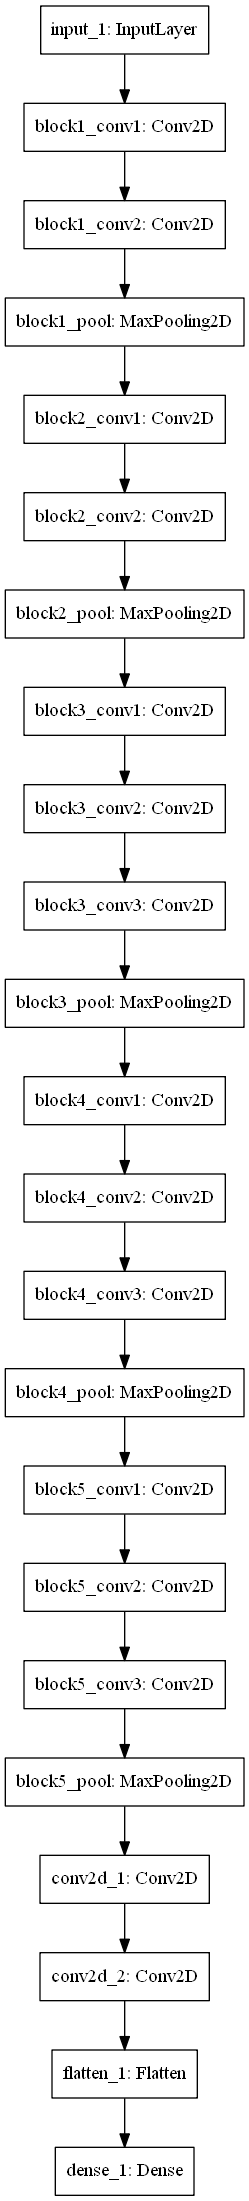

In [22]:
plot_model(model3, to_file='model3.png')

In [23]:
#fit
model3.fit_generator(train_generator, epochs=20, validation_data=test_generator, 
                     callbacks=[tfboard_callback, stp_callback])

Epoch 1/20
1050/1050 [==============================] - 1444s 1s/step - loss: 0.2183 - accuracy: 0.9375 - val_loss: 0.2105 - val_accuracy: 0.9375
Epoch 2/20
1050/1050 [==============================] - 1490s 1s/step - loss: 0.1747 - accuracy: 0.9429 - val_loss: 0.1383 - val_accuracy: 0.9492
Epoch 3/20
1050/1050 [==============================] - 1471s 1s/step - loss: 0.1407 - accuracy: 0.9528 - val_loss: 0.1226 - val_accuracy: 0.9567
Epoch 4/20
1050/1050 [==============================] - 1451s 1s/step - loss: 0.1221 - accuracy: 0.9589 - val_loss: 0.1101 - val_accuracy: 0.9607
Epoch 5/20
1050/1050 [==============================] - 1477s 1s/step - loss: 0.1110 - accuracy: 0.9626 - val_loss: 0.1233 - val_accuracy: 0.9638
Epoch 6/20
1050/1050 [==============================] - 1497s 1s/step - loss: 0.1036 - accuracy: 0.9650 - val_loss: 0.1019 - val_accuracy: 0.9657
Epoch 7/20
1050/1050 [==============================] - 1492s 1s/step - loss: 0.0979 - accuracy: 0.9671 - val_loss: 0.1231 -

### Observation
1. **Validation loss gradually comes down with some fluctuations but ultimately settles at epoch 15.**
2. **With patience=3, the callback stops the training at epoch=18 to prevent overfitting**
3. **Validation accuracy sets at 97-98%**

## Tensorboard M3 (Blue is Validation)

<img src="https://imgur.com/iSYyfY1.png">

<img src="https://imgur.com/Zxiy5Wt.png">